In [ ]:
# Spoken digits classification with Xylo

In [ ]:
# - Import and configure matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 3]
plt.rcParams["figure.dpi"] = 100

# - Nice printing
from rich import print

# - Torch and numpy
import torch
import numpy as np

# - For displaying images
from IPython.display import Image

Rockpool is a deep learning library for SNNs, designed to make it very easy to design, train and deploy applications to neuromorphic hardware.

Documentation: https://rockpool.ai


## Getting started with a single LIF neuron


In [2]:
# - The LIF module is a Leaky Integrate and Fire spiking neuron
from rockpool.nn.modules import LIF

# - Create a single LIF neuron to examine
lif = LIF(1, threshold=10.)
print(lif)

LIF  with shape (1, 1)

In [3]:
# - Generate some Poissonian spiking input to the neuron
f = 0.02
T = 500
Nin = 1
input_sp = np.random.rand(T, Nin) < f


In [4]:
# - Evolve the neuron by passing the data through
#   `record = True` records and returns internal state
out, _, rec_dict = lif(input_sp, record = True)


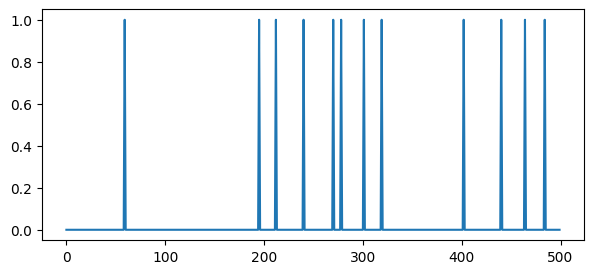

In [5]:
# - plot the output events
plt.plot(out.squeeze())
plt.show()


In [6]:
# - Let's look at the recorded state. What did we get back from the evolution?
rec_dict.keys()


dict_keys(['irec', 'spikes', 'isyn', 'vmem'])

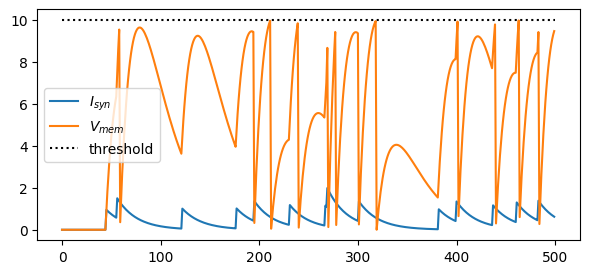

In [7]:
# - Let's plot the synaptic current `isyn` and membrane potential `vmem`
plt.plot(rec_dict['isyn'].squeeze(), label='$I_{syn}$')
plt.plot(rec_dict['vmem'].squeeze(), label='$V_{mem}$')
plt.plot([0, 500], [10, 10], 'k:', label='threshold')
plt.legend()
plt.show()


In [8]:
# - Rockpool modules all have a `state()` method which returns the internal module state
print(lif.state())


{'spikes': array([0.]), 'isyn': array([[0.62208639]]), 'vmem': array([9.46060609])}

In [9]:
# - Rockpool modules all have a `parameters()` method which returns the trainable parameters of a module
print(lif.parameters())


{'tau_mem': array([0.02]), 'tau_syn': array([[0.02]]), 'bias': array([0.]), 'threshold': array(10.)}

In [10]:
# - Rockpool modules all have a `simulation_parameters()` method which returns the non-trainable parameters
print(lif.simulation_parameters())


{'_has_rec': False, 'w_rec': array([[0.]]), 'dt': 0.001, 'noise_std': 0.0, 'max_spikes_per_dt': 65536.0}

## The Data

For this project, we will work with the original audios from the Heidelberg digist datset [Heidelberg Digits](https://compneuro.net/datasets/hd_audio.tar.gz)

Once you download the data, place it inside the data folder. In this folder you will also find the dataset.py
This script takes care of the partition of the data.

Let's call the dataset so you get more familiar with it:


#### Original audios

INFO:root:
Loading config file according to the percentage: train = 0.8 val = 0.1 test =0.1
INFO:root:
Verifying if data has been split in [0.5, 0.5, 0.5]seconds for train-val-test...
INFO:root:
A data split of [0.5, 0.5, 0.5]seconds for train-val-test has been generated before
Loading this split partition...
Split data is ready


train contains 4330 files

Audio sample with label 0

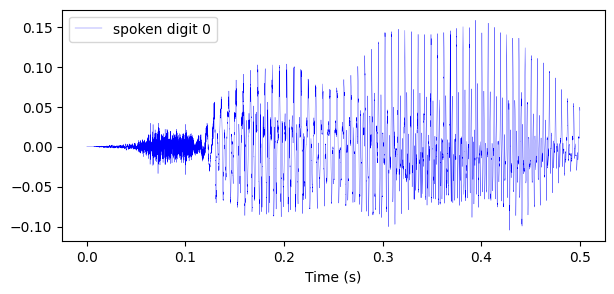

In [11]:
import logging
from data.dataset import DATA_PATH, SpokenDigits
logging.basicConfig(level=logging.INFO)

# - Specify partition (train, val, test)
partition = "train"

# - Specify laguage of the spoken digits (english or german)
language = "english"

# - Specify digits to be used.
# - Since we want to train an SNN that can be mapped onto Xylo, we will only choose the first 8 spoken digits
digits=[0,1,2,3,4,5,6,7,8,9]

# - Specify the percentage of train-val-test
# the sum of the percentage for train, val, and test must be equal to 1
ps = [0.8, 0.1, 0.1]

# - Specify the time in seconds for each file in each partition
# - We split the data in equal durations since all of the files in pur batch must be of the same shape during training.
# - Based on the data, we recommend split it in half a second samples (0.5 seconds)
split_time_per_partition = [0.5,0.5,0.5] #(0.5 seconds for each partition: train, val and test)

data_train = SpokenDigits(
    partition=partition,
    digits=digits,
    language=language,
    percentage_train=ps[0],
    percentage_val=ps[1],
    percentage_test=ps[2],
    split_time_per_partition = split_time_per_partition,
)

print(f'{partition} contains {data_train.__len__()} files')

# - Load audio sample
audio_example = data_train.__getitem__(0)
signal = audio_example[0]
label = audio_example[1]
print(f'Audio sample with label {label}')

# - Plot the audio sample
time_vector = np.arange(0, split_time_per_partition[0],(1/data_train.sample_rate))
plt.plot(time_vector, signal[0], 'b', linewidth = 0.2, label=f'spoken digit {label}')
plt.xlabel("Time (s)")
plt.legend()
plt.show()



### Spike-encoded audios

To train a spiking neural network, we need spike-encoded inputs.
Ther are many ways to transform the one-dimensional audio signal into spikes.
In this project, we will use a transformation that simulates the audio-front-end in our XyloAudio3 chip.
This AFE simulator returns a 16 channel spike train that can be used as input to our SNN.


The simulation of our AFE is computationally intensive, as it can not be parallelized. Wer therefore recommend cacheing the data.
The cacheing will significalty speed our training.
The code above will call some AFE samples so we can visualize them. However, you should have cache the data beforehand.
To do so, please run datamodule.py


In [17]:
logging.basicConfig(level=logging.INFO)
import os
from training_utils.cache_utils import create_config_str
from tonic.audio_transforms import FixLength
from training_utils.data_transforms import SwapAxes, AFESim3
from data.dataset import DATA_PATH
from training.datamodule import SpokenDigitsDataModule

# - Specify cache data folder
cache_path = os.path.join(DATA_PATH, "cache_data")

#- Specify the sampling frerquency of the audios
sampling_freq = 48000

params_dataset ={"digits":digits,
                 "language": language,
                 "sample_rate":sampling_freq,
                 "percentage_train":ps[0],
                 "percentage_val":ps[1],
                 "percentage_test":ps[2],
                 "split_time_per_partition":split_time_per_partition}


transform = [
    FixLength(length=int(sampling_freq * split_time_per_partition[0]), axis=1),
    AFESim3(fs=sampling_freq, dt=0.009994, spike_gen_mode="divisive_norm"),
    SwapAxes(),
]


dl = SpokenDigitsDataModule(
    batch_size_train = 100, batch_size_val = 500, batch_size_test = 500,
    params_dataset = params_dataset,
    transform=transform,
    cache_dataset=True, 
    cache_path = cache_path,
    reset_cache=False, 
)
dl.setup()

train_dataloader = dl.train_dataloader()
data_train, label_train = next(iter(train_dataloader))


INFO:root:Transforms applied:
Transform
	[FixLength(length=24000, axis=1), AFESim3(fs=48000, spike_gen_mode='divisive_norm', fixed_threshold=None, dn_EPS=32, rate_scale_factor=63, low_pass_averaging_window=0.084, dt=0.009994), SwapAxes(ax1=0, ax2=1)]
Target Transform
	[]
INFO:root:Automatic Class Balancing via Weighted Random Sampler applied:
Train set	False
Val set	False
Test set	False
INFO:root:
Loading config file according to the percentage: train = 0.8 val = 0.1 test =0.1
INFO:root:
Verifying if data has been split in [0.5, 0.5, 0.5]seconds for train-val-test...
INFO:root:
A data split of [0.5, 0.5, 0.5]seconds for train-val-test has been generated before
Loading this split partition...
Split data is ready
INFO:root:
Loading config file according to the percentage: train = 0.8 val = 0.1 test =0.1
INFO:root:
Verifying if data has been split in [0.5, 0.5, 0.5]seconds for train-val-test...
INFO:root:
A data split of [0.5, 0.5, 0.5]seconds for train-val-test has been generated before


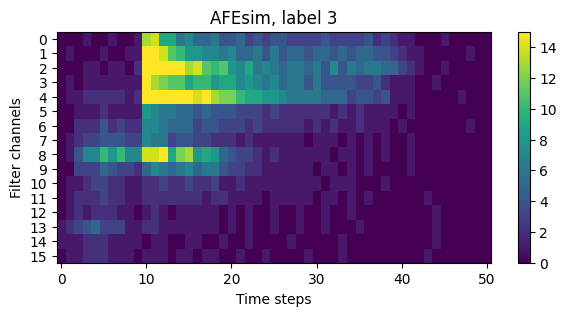

In [19]:
# - Plot the first sample of the train data loader
afe_sample = data_train[0]
figure_size = (7,3)
figure, ax = plt.subplots(
            figsize=figure_size,
            facecolor='white')

image = ax.imshow(afe_sample.T,
              aspect='auto')
ax.figure.colorbar(image)
ax.set_title(f"AFEsim, label {int(label_train[0])}")

ax.set_yticks(range(16))
ax.set_yticklabels(range(16))#, fontsize = fig_label_size-2)
ax.set_ylabel('Filter channels')#,fontsize = fig_label_size-1)
ax.set_xlabel('Time steps')#,fontsize = fig_label_size-1)

plt.show()

## Network definition

Here we define an SNN with residual connections using Rockpool.
This is just an example of an SNN, your task is to create your own SNN and train it to classify the spoken digits.

(tip: look at predefined networks in Rockpool)

In [27]:
import os
from pathlib import Path
notebook_path = Path(os.path.abspath(""))


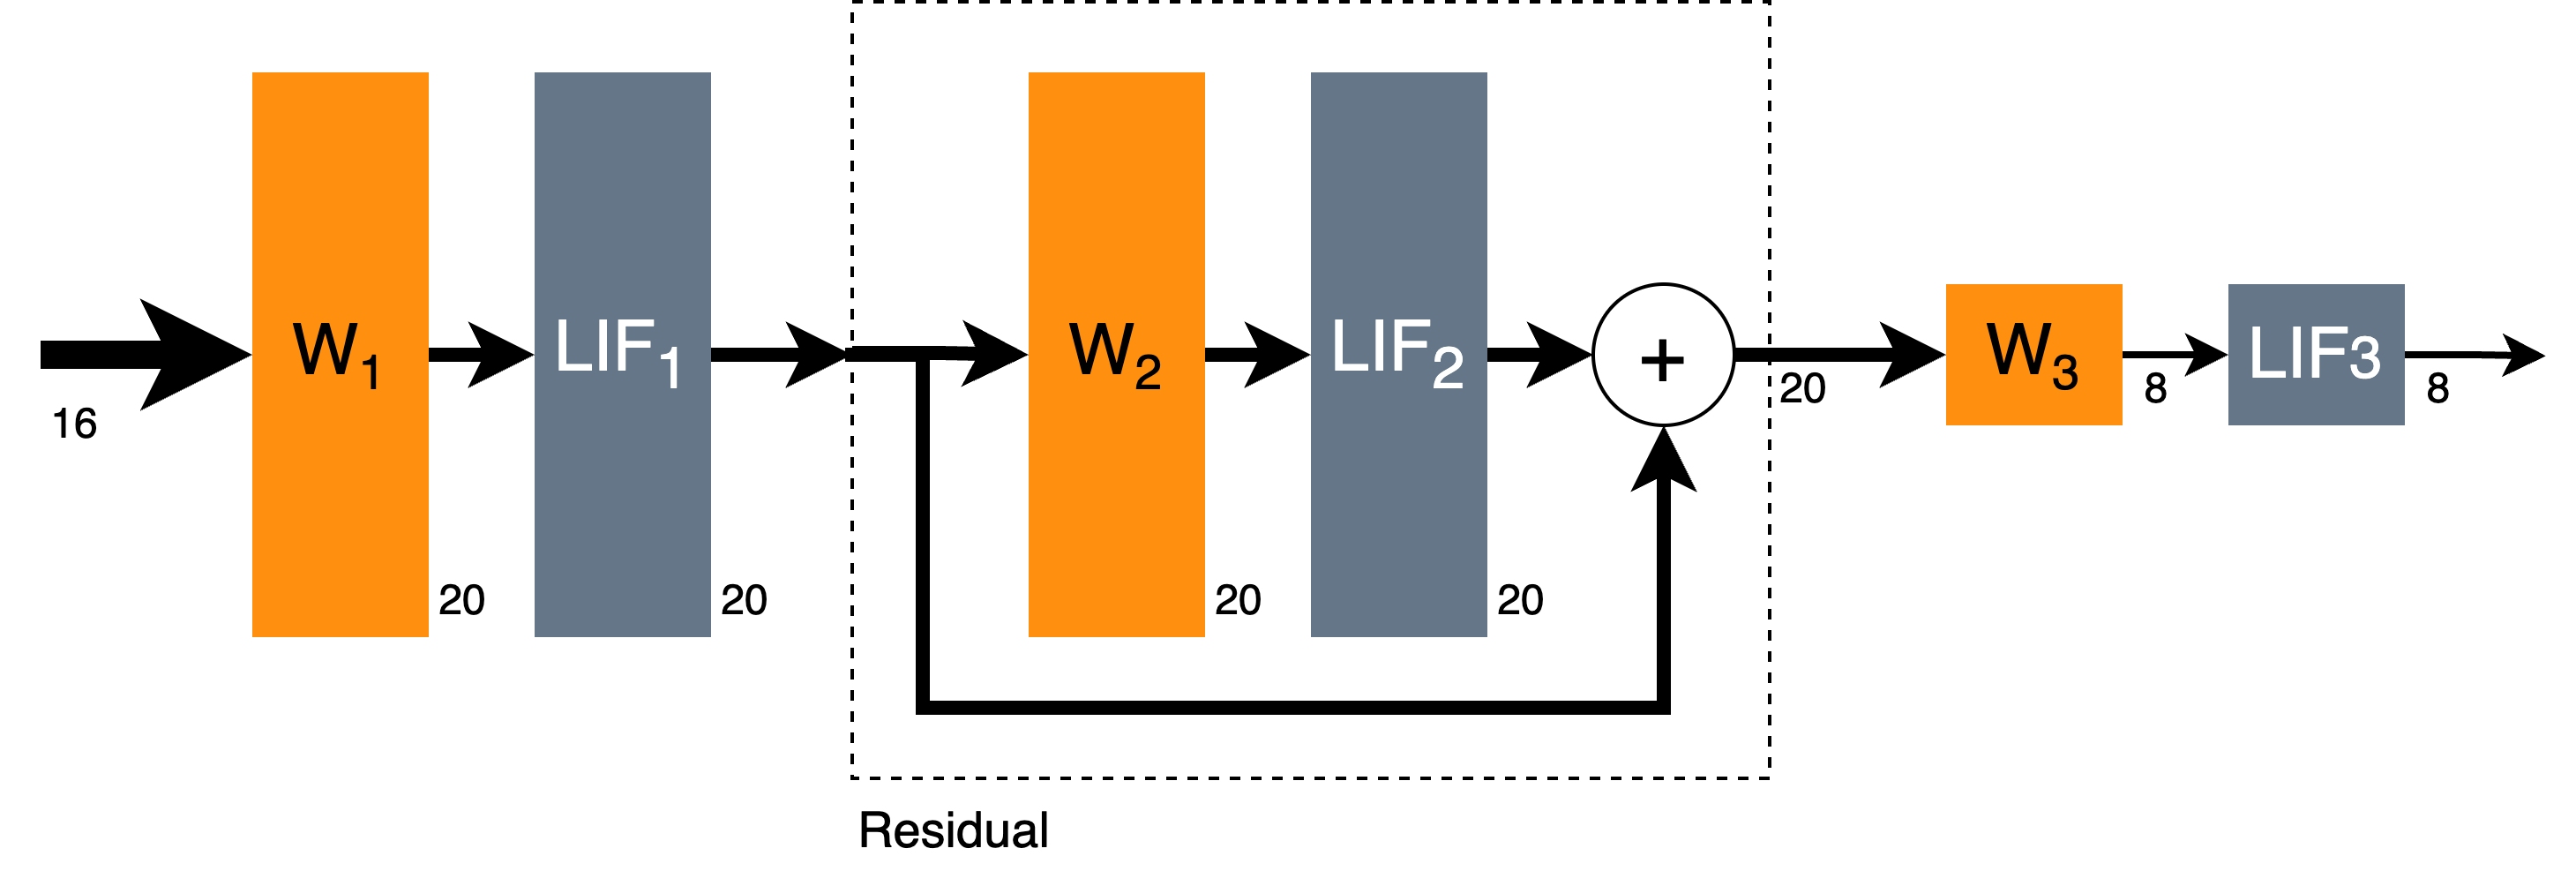

In [ ]:
# - Show an image of the target network architecture
Image(f'{notebook_path}/images/network-layout-shd.png')

In [51]:
# - Import the required torch-backed modules and combinators
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual

net_channels = 16
net_dt = 10e-3

# - Define a simple network architecture
Nin = net_channels
Nhid = 20
Nout = 10

net = Sequential(
    LinearTorch((Nin, Nhid)),
    LIFTorch(Nhid),

    Residual(
        LinearTorch((Nhid, Nhid)),
        LIFTorch(Nhid),
    ),

    LinearTorch((Nhid, Nout)),
    LIFTorch(Nout),
)
print(net)


TorchSequential  with shape (16, 10) {
    LinearTorch '0_LinearTorch' with shape (16, 20)
    LIFTorch '1_LIFTorch' with shape (20, 20)
    TorchResidual '2_TorchResidual' with shape (20, 20) {
        LinearTorch '0_LinearTorch' with shape (20, 20)
        LIFTorch '1_LIFTorch' with shape (20, 20)
    }
    LinearTorch '3_LinearTorch' with shape (20, 10)
    LIFTorch '4_LIFTorch' with shape (10, 10)
}

In [52]:
# - By default all parameters are trainable
print(
    {
        module_name: list(module_parameters.keys())
        for module_name, module_parameters in net.parameters().items()
    }
)



{
    '0_LinearTorch': ['weight'],
    '1_LIFTorch': ['tau_mem', 'tau_syn', 'bias', 'threshold'],
    '2_TorchResidual': ['0_LinearTorch', '1_LIFTorch'],
    '3_LinearTorch': ['weight'],
    '4_LIFTorch': ['tau_mem', 'tau_syn', 'bias', 'threshold']
}

In [53]:
# - Import the `Constant` decorator, so we can specify non-trainable parameters
from rockpool.parameters import Constant

# - Define shared neuron parameters to use
neuron_parameters = {
    'tau_mem': Constant(50e-3),
    'tau_syn': Constant(20e-3),
    'bias': Constant(0.),
    'threshold': Constant(1.),
    'dt': net_dt,
}

# - Define the network with shared parameters
net = Sequential(
    LinearTorch((Nin, Nhid)),
    LIFTorch(Nhid, **neuron_parameters),

    Residual(
        LinearTorch((Nhid, Nhid)),
        LIFTorch(Nhid, **neuron_parameters),
    ),

    LinearTorch((Nhid, Nout)),
    LIFTorch(Nout, **neuron_parameters),
)

In [54]:
# - Now only weights are trainable
print(
    "Trainable parameters:",
    {
        module_name: list(module_parameters.keys())
        for module_name, module_parameters in net.parameters().items()
    }
)
print(
    "Non-trainable parameters:",
    {
        module_name: list(module_parameters.keys())
        for module_name, module_parameters in net.simulation_parameters().items()
    }
)



Trainable parameters:
{
    '0_LinearTorch': ['weight'],
    '1_LIFTorch': [],
    '2_TorchResidual': ['0_LinearTorch', '1_LIFTorch'],
    '3_LinearTorch': ['weight'],
    '4_LIFTorch': []
}

Non-trainable parameters:
{
    '0_LinearTorch': [],
    '1_LIFTorch': [
        'leak_mode',
        'dt',
        '_has_rec',
        'w_rec',
        'noise_std',
        'tau_mem',
        'tau_syn',
        'bias',
        'threshold',
        'learning_window',
        'spike_generation_fn',
        'max_spikes_per_dt'
    ],
    '2_TorchResidual': ['0_LinearTorch', '1_LIFTorch'],
    '3_LinearTorch': [],
    '4_LIFTorch': [
        'leak_mode',
        'dt',
        '_has_rec',
        'w_rec',
        'noise_std',
        'tau_mem',
        'tau_syn',
        'bias',
        'threshold',
        'learning_window',
        'spike_generation_fn',
        'max_spikes_per_dt'
    ]
}

## Training loop

In [55]:
# - Import optimizer and loss function from pytorch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# - Get the optimiser functions
optimizer = Adam(net.parameters().astorch(), lr=1e-3)

# - Loss function
loss_fun = CrossEntropyLoss()



In [59]:
train = True

if train:
    # - Training Loop
    num_epochs = 2
    for e in range(num_epochs):
        # - Loop over dataset, getting batches
        for events, labels in train_dataloader:
            new_labels=[]
            # - Change input events to float
            events = events.to(torch.float32)

            # - Change labels 
            for label in labels:
                new_labels.append(int(label))
            
            new_labels = torch.tensor(new_labels)
             # - Zero the optimizer gradients
            optimizer.zero_grad()

            # - Evolve the network with thi batch
            output, _, _ = net(events)

            # - Get the prediction -- number of spikes in each channel
            pred = torch.sum(output, dim=1)

            # - Get the loss value for this batch
            loss = loss_fun(pred, new_labels)

            # - Compute gradients with backward step and update parameters
            loss.backward()
            optimizer.step()

        # - Print the current loss
        print(f'Epoch {e}/{num_epochs}, loss {loss.item():.2e}')


Epoch 0/2, loss 1.18e+02

Epoch 1/2, loss 2.60e+00